In [1]:
import os
import pathlib
import random
import shutil
from pathlib import Path
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import pandas as pd
import torch
from PIL import Image
from IPython import display
from ultralytics import YOLO
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import draw_bounding_boxes


In [2]:
# Explore the imported data
base_dir = Path("archive")
images_dir = base_dir / "images"
anns_dir = base_dir / "annotations"
print(images_dir)
print(anns_dir)

archive/images
archive/annotations


In [39]:
xml_path = anns_dir / "0e6e87c3-cam103_20250326_165039.xml"
# !head -n  50 $xml_path
tree = ET.parse(xml_path)
root = tree.getroot()
print(root.tag)

annotation


In [4]:
classes = ["passenger_car", "lorry", "utility_vehicle", "bus", "tram", "pedestrian"]

class_mapping = {val: idx for idx, val in enumerate(classes)}
print(class_mapping)

{'passenger_car': 0, 'lorry': 1, 'utility_vehicle': 2, 'bus': 3, 'tram': 4, 'pedestrian': 5}


In [5]:
bounding_boxes, labels = [], []
for obj in root.findall("object"):
    label = obj.find("name").text
    labels.append(label)
    bndbox = obj.find("bndbox")
    xmin = int(bndbox.find("xmin").text)
    ymin = int(bndbox.find("ymin").text)
    xmax = int(bndbox.find("xmax").text)
    ymax = int(bndbox.find("ymax").text)
    bounding_boxes.append([xmin, ymin, xmax, ymax])
for label, bounding_box in zip(labels, bounding_boxes):
    print(f"{label}: {bounding_box}")


tram: [844, 145, 1279, 503]
passenger_car: [899, 320, 1023, 454]
bus: [501, 172, 963, 616]
bus: [361, 164, 549, 271]
pedestrian: [177, 258, 198, 303]
pedestrian: [205, 259, 223, 305]
pedestrian: [219, 255, 240, 308]
passenger_car: [680, 172, 758, 230]
passenger_car: [809, 147, 844, 171]
passenger_car: [741, 124, 765, 140]
passenger_car: [772, 131, 790, 147]
passenger_car: [791, 126, 807, 143]
passenger_car: [501, 129, 536, 150]


In [6]:
bboxes_tensor = torch.tensor(bounding_boxes, dtype=torch.float32)
print(bboxes_tensor)

tensor([[ 844.,  145., 1279.,  503.],
        [ 899.,  320., 1023.,  454.],
        [ 501.,  172.,  963.,  616.],
        [ 361.,  164.,  549.,  271.],
        [ 177.,  258.,  198.,  303.],
        [ 205.,  259.,  223.,  305.],
        [ 219.,  255.,  240.,  308.],
        [ 680.,  172.,  758.,  230.],
        [ 809.,  147.,  844.,  171.],
        [ 741.,  124.,  765.,  140.],
        [ 772.,  131.,  790.,  147.],
        [ 791.,  126.,  807.,  143.],
        [ 501.,  129.,  536.,  150.]])


In [7]:
from torchvision.io import read_image

image_path = images_dir / "0e6e87c3-cam103_20250326_165039.jpg"
image = read_image(str(image_path))
image = image[:3, :, :]
print(image.shape)

torch.Size([3, 720, 1280])


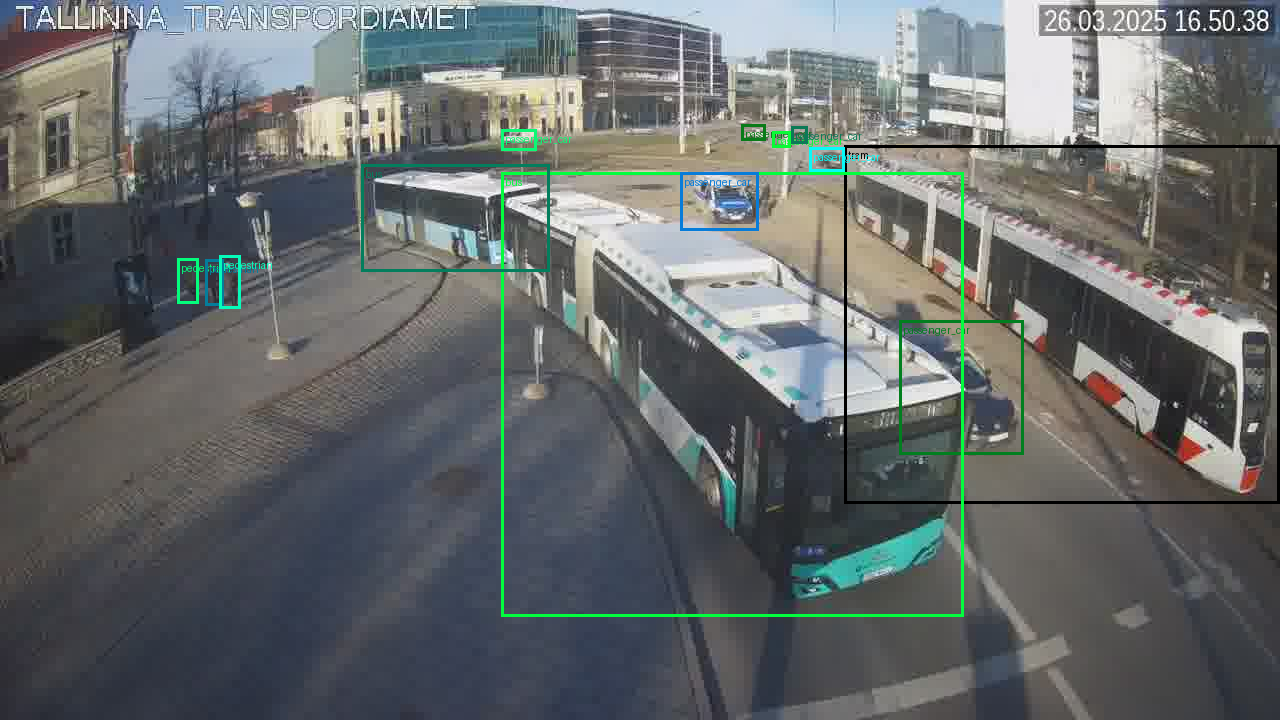

In [8]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image


image = draw_bounding_boxes(
    image=image,
    boxes=bboxes_tensor,
    labels=labels,
    width=3,
    fill=False
)
to_pil_image(image)

In [9]:
width, height = int(root.find("size").find("width").text), int(root.find("size").find("height").text)
print(width, height)
def xml_to_yolo(bbox, width, height):
    """inputs:
    bbox = [xmin, ymin, xmax, ymax], width = width of image in pixels, height = height of image in pixels
    outputs:
    [x_center, y_center, bb_width, bb_height], bounding box is centered at (x_center, y_center) and of size bb_width and bb_height. All values measured as fraction of the image size
    """
    # Normalize
    xmin, ymin, xmax, ymax = bbox
    x_center = ((xmin + xmax) / 2) / width
    y_center = ((ymin + ymax) / 2) / height
    bb_width = (xmax - xmin) / width
    bb_height = (ymax - ymin) / height
    return [x_center, y_center, bb_width, bb_height]

xml_to_yolo([xmin, ymin, xmax, ymax], width,height)

1280 720


[0.405078125, 0.19375, 0.02734375, 0.029166666666666667]

In [10]:
def parse_annonations(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    objects = []
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)
    for obj in root.findall("object"):
        label = obj.find("name").text
        class_id = class_mapping[label]
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        yolo_bbox = xml_to_yolo([xmin, ymin, xmax, ymax], width, height)
        objects.append([class_id] + yolo_bbox)

    return objects
objects = parse_annonations(xml_path)
print(objects)
first_object = objects[0]
print(first_object)

[[4, 0.829296875, 0.45, 0.33984375, 0.49722222222222223], [0, 0.75078125, 0.5375, 0.096875, 0.18611111111111112], [3, 0.571875, 0.5472222222222223, 0.3609375, 0.6166666666666667], [3, 0.35546875, 0.3020833333333333, 0.146875, 0.1486111111111111], [5, 0.146484375, 0.38958333333333334, 0.01640625, 0.0625], [5, 0.1671875, 0.39166666666666666, 0.0140625, 0.06388888888888888], [5, 0.179296875, 0.3909722222222222, 0.01640625, 0.07361111111111111], [0, 0.56171875, 0.2791666666666667, 0.0609375, 0.08055555555555556], [0, 0.645703125, 0.22083333333333333, 0.02734375, 0.03333333333333333], [0, 0.58828125, 0.18333333333333332, 0.01875, 0.022222222222222223], [0, 0.61015625, 0.19305555555555556, 0.0140625, 0.022222222222222223], [0, 0.62421875, 0.18680555555555556, 0.0125, 0.02361111111111111], [0, 0.405078125, 0.19375, 0.02734375, 0.029166666666666667]]
[4, 0.829296875, 0.45, 0.33984375, 0.49722222222222223]


In [11]:
def write_label(objects, txt_path):
    with open(txt_path, "w") as f:
        for obj in objects:
            f.write(" ".join(str(el) for el in obj))
            f.write("\n")

result = write_label(objects, "yolo_format.txt")
# !head -n 6 yolo_format.txt

4 0.829296875 0.45 0.33984375 0.49722222222222223
0 0.75078125 0.5375 0.096875 0.18611111111111112
3 0.571875 0.5472222222222223 0.3609375 0.6166666666666667
3 0.35546875 0.3020833333333333 0.146875 0.1486111111111111
5 0.146484375 0.38958333333333334 0.01640625 0.0625
5 0.1671875 0.39166666666666666 0.0140625 0.06388888888888888


In [12]:
def convert (fin_path, fout_path):
    Image.open(fin_path).convert("RGB").save(fout_path, format="JPEG")

In [37]:
test_image = image_path
convert(test_image, "test_image.jpg")

# display.display(
#     Image.open("test_image.jpg"),
# )

In [14]:
yolo_base = Path("data_yolo")
# Clear out the directory, if it already exists. Get a different train / validation split
# each time by d images are clearing out old ones.

shutil.rmtree(yolo_base, ignore_errors=True)

(yolo_base / "images" / "train").mkdir(parents=True)
(yolo_base / "images" / "val").mkdir(parents=True)
(yolo_base / "labels" / "train").mkdir(parents=True)
(yolo_base / "labels" / "val").mkdir(parents=True)

# !tree $yolo_base

data_yolo
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

7 directories, 0 files


In [15]:
from tqdm import tqdm

train_ratio = 0.8

images = list(images_dir.glob("*"))

for img in tqdm(images):
    split = "train" if random.random() < train_ratio else "val"
    xml_path = anns_dir / f"{img.stem}.xml"

    label_dest = yolo_base / "labels" / split / f"{img.stem}.txt"
    if xml_path.exists():
        # Parse normally
        parsed = parse_annonations(xml_path)
        write_label(parsed, label_dest)
    else:
        # NO OBJECTS → create empty label file
        open(label_dest, "w").close()


    img_dest = yolo_base / "images" / split / f"{img.stem}.jpg"
    convert(img, img_dest)


100%|██████████| 1200/1200 [00:04<00:00, 269.56it/s]


In [16]:
train_count = len(list((yolo_base / "images" / "train").glob("*")))
val_count = len(list((yolo_base / "images" / "val").glob("*")))
print(train_count, val_count)

927 273


In [17]:
# Training YOLO model
# Data for training YOLO model needs to described in a YAML file(a superset of JSON)

metadata = {
    "path": str(yolo_base.absolute()),
    "train": "images/train",
    "val": "images/val",
    "names": classes,
    "nc": len(classes),
}

print(metadata)

{'path': '/Users/mac/road_users_detection/data_yolo', 'train': 'images/train', 'val': 'images/val', 'names': ['passenger_car', 'lorry', 'utility_vehicle', 'bus', 'tram', 'pedestrian'], 'nc': 6}


In [38]:
import yaml

yolo_config = "data.yaml"

yaml.safe_dump(metadata, open(yolo_config, "w"))

# !cat data.yaml

In [19]:

model = YOLO("yolo11s.pt")
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_runnin

In [20]:

# model = model = YOLO("yolo11s.pt")
#
# model.train(
#     data="data.yaml",
#     epochs=50,
#     patience=10,
# )


In [21]:
model = YOLO("/Users/mac/road_users_detection/runs/detect/train11/weights/best.pt")

In [22]:
save_dir = Path("runs/detect/train11")
print(save_dir)

runs/detect/train11


In [23]:
# !tree $save_dir

runs/detect/train11
├── args.yaml
├── BoxF1_curve.png
├── BoxP_curve.png
├── BoxPR_curve.png
├── BoxR_curve.png
├── confusion_matrix_normalized.png
├── confusion_matrix.png
├── labels.jpg
├── results.csv
├── results.png
├── train_batch0.jpg
├── train_batch1.jpg
├── train_batch2.jpg
├── train_batch2400.jpg
├── train_batch2401.jpg
├── train_batch2402.jpg
├── val_batch0_labels.jpg
├── val_batch0_pred.jpg
├── val_batch1_labels.jpg
├── val_batch1_pred.jpg
├── val_batch2_labels.jpg
├── val_batch2_pred.jpg
└── weights
    ├── best.pt
    └── last.pt

2 directories, 24 files


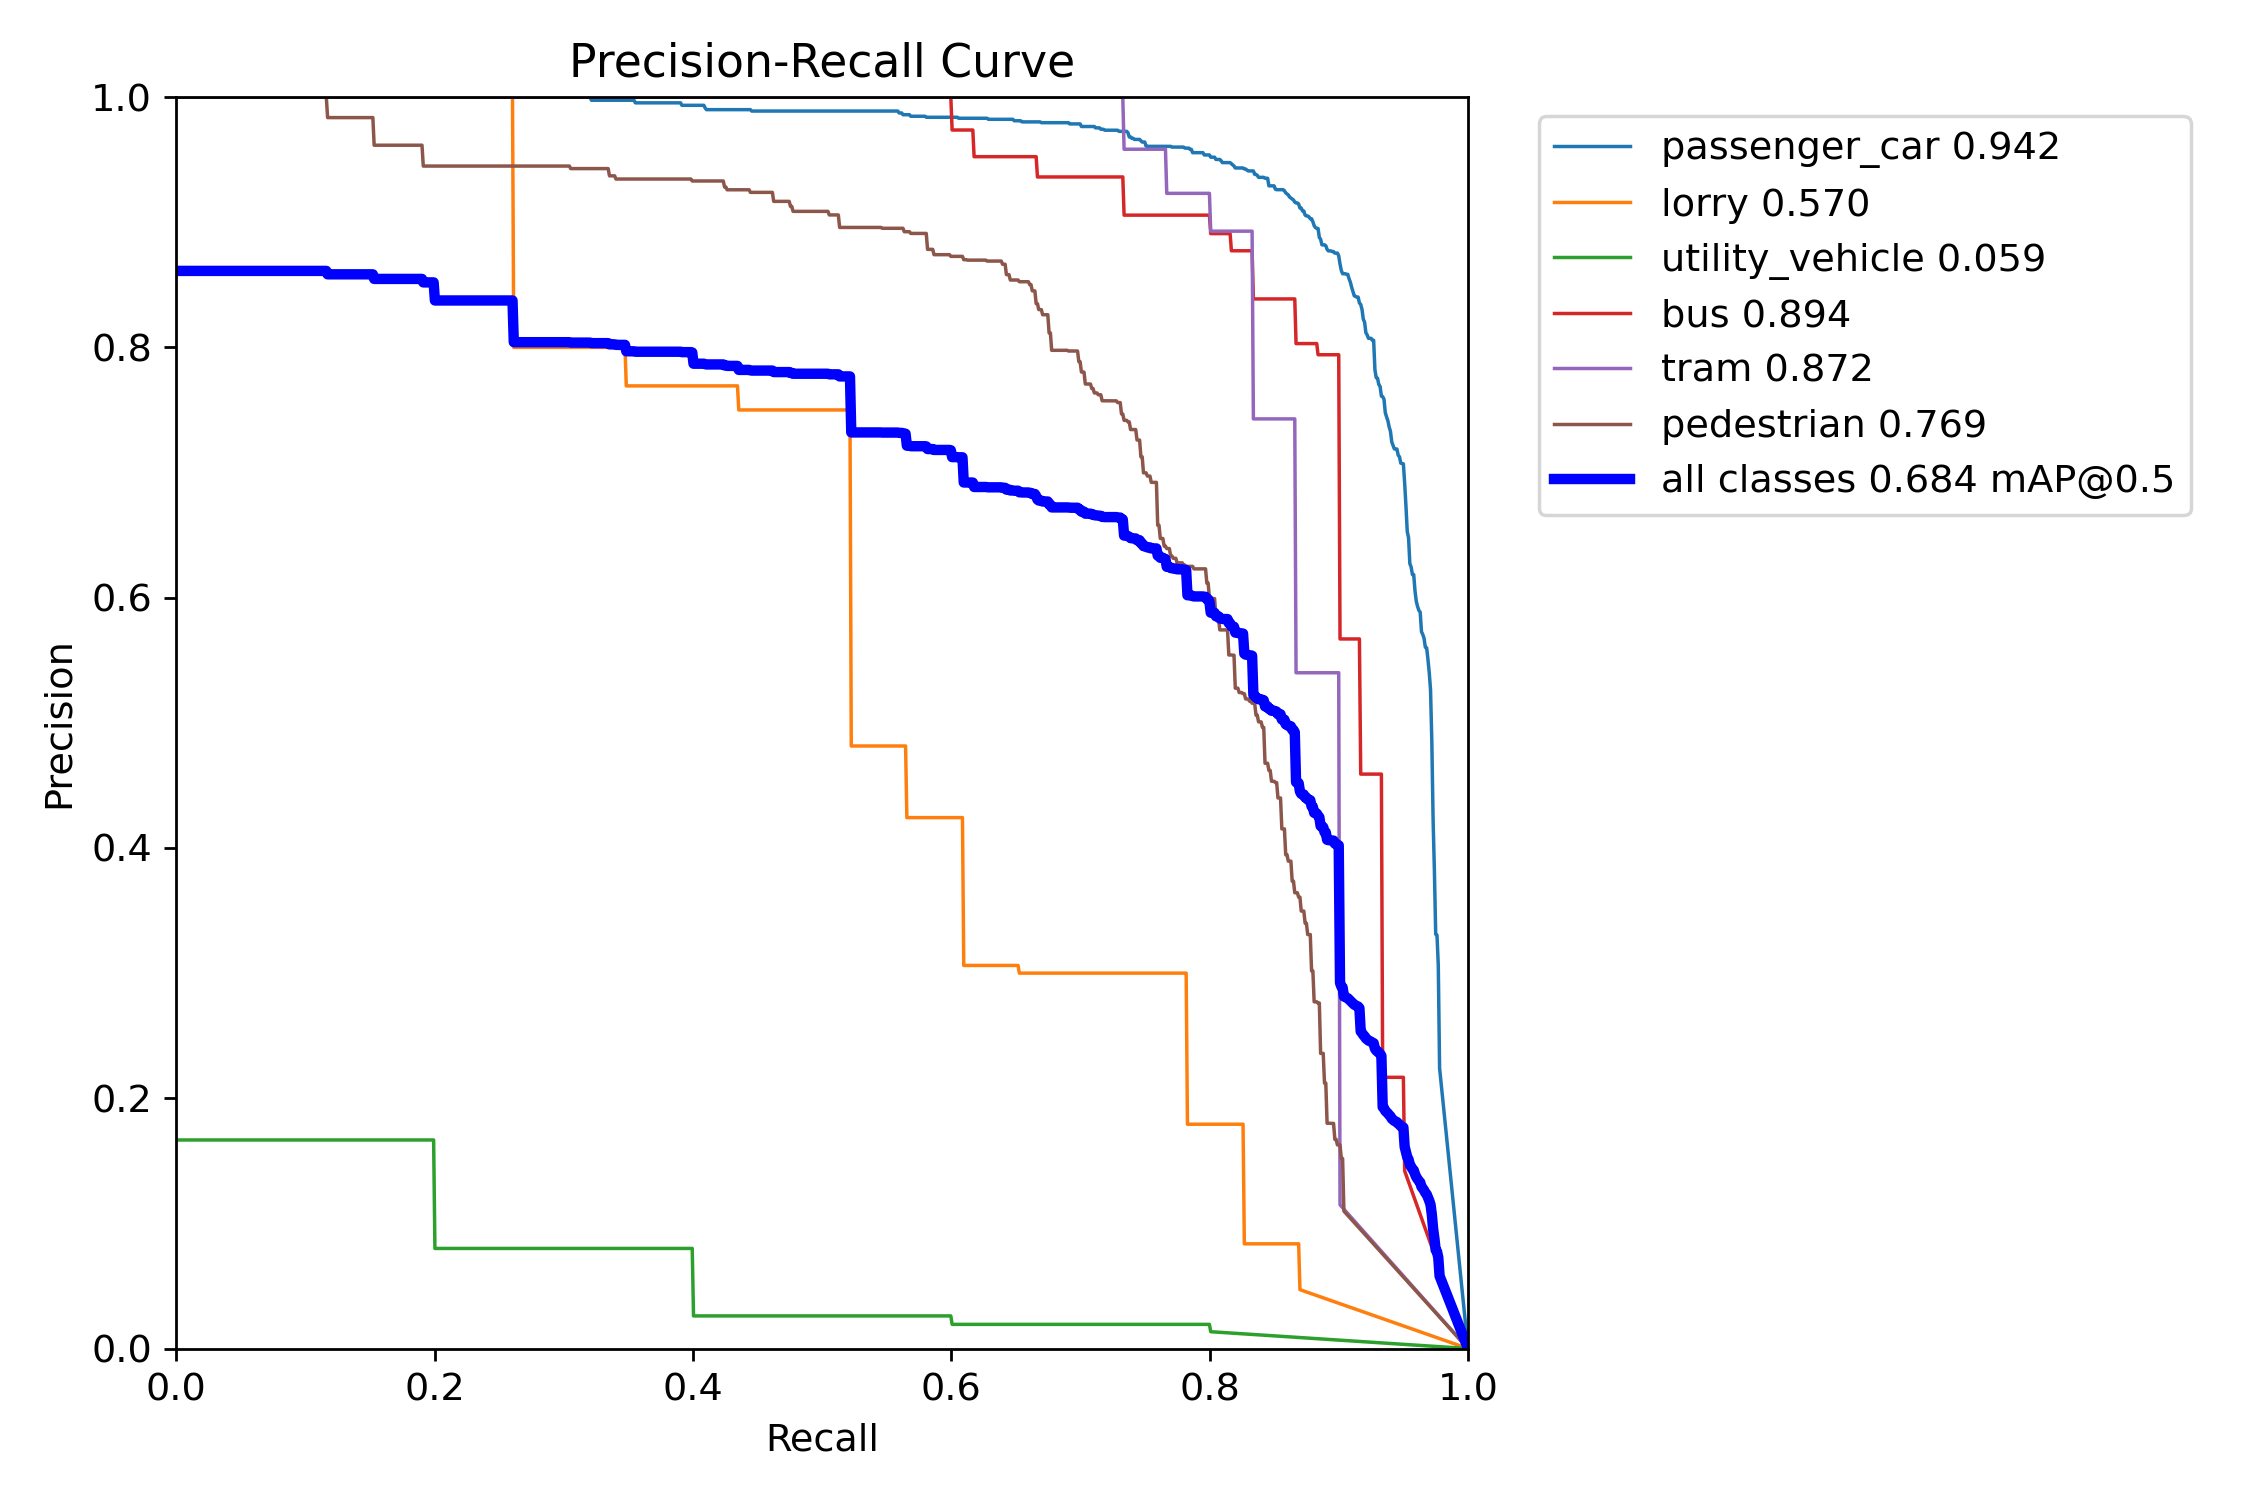

In [24]:
Image.open(save_dir / "BoxPR_curve.png")

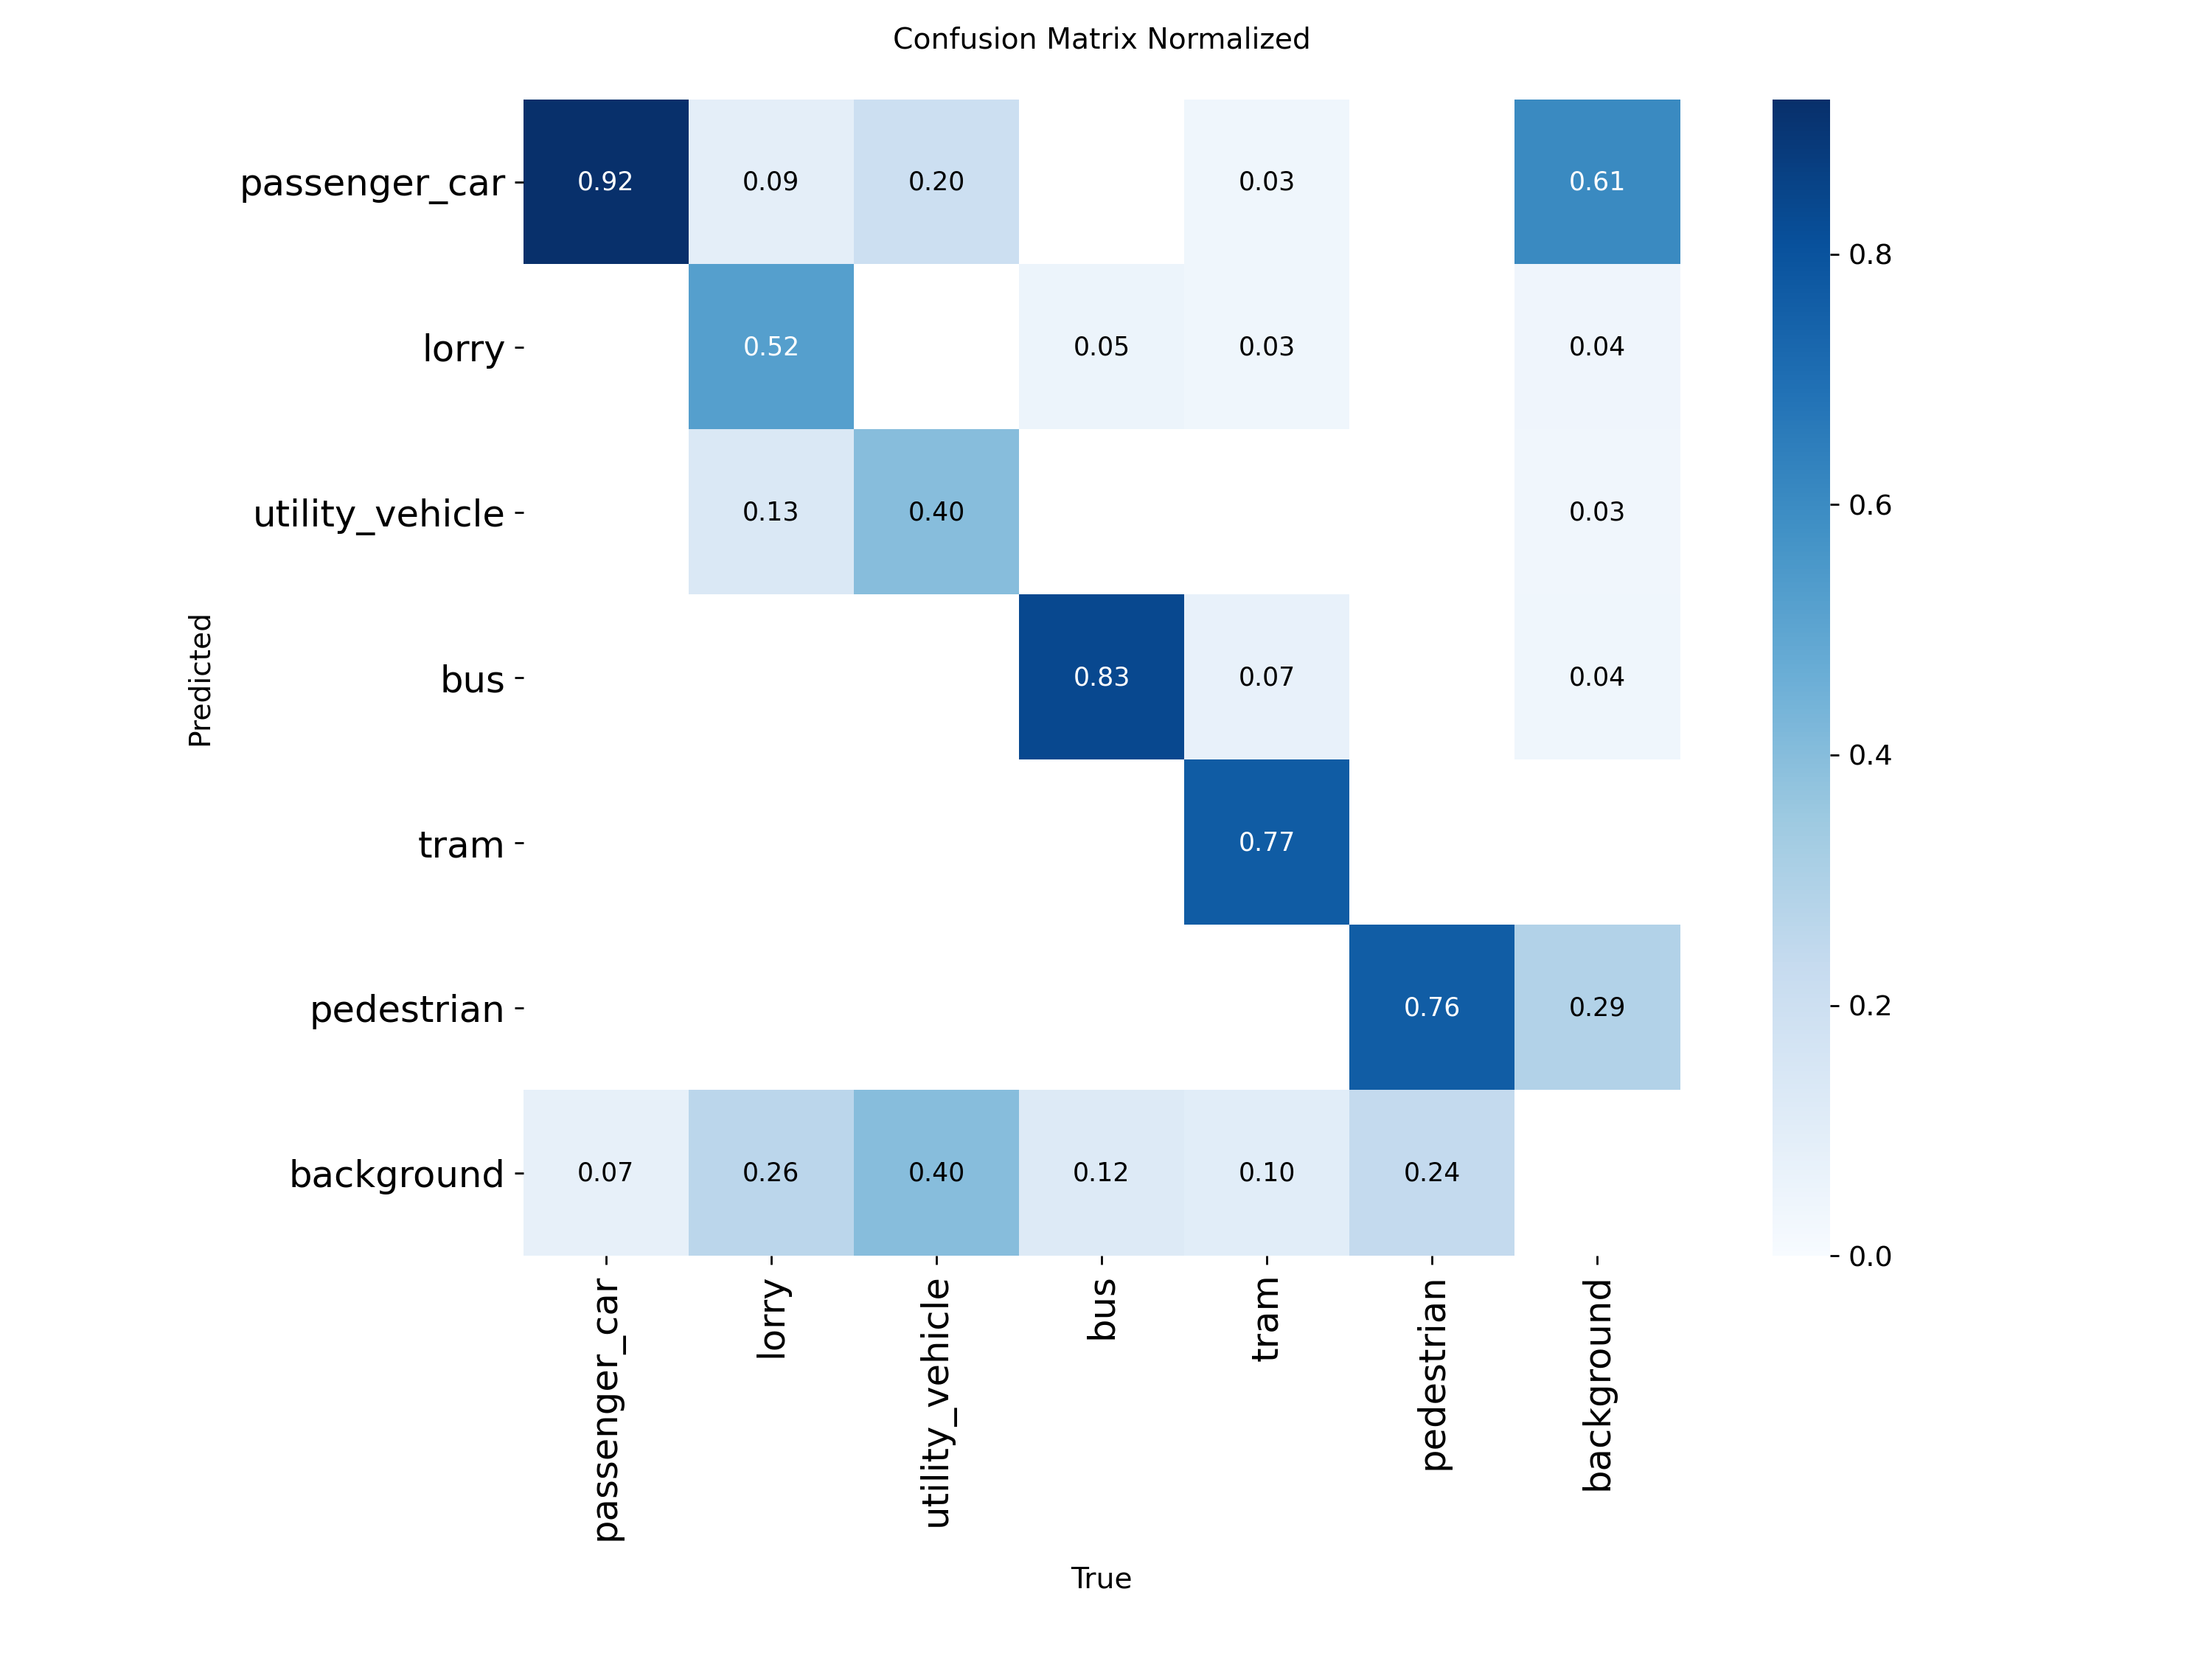

In [25]:
Image.open(save_dir / "confusion_matrix_normalized.png")

In [26]:
df = pd.read_csv(save_dir / "results.csv", skipinitialspace=True).set_index("epoch")
df.head()

,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
epoch,,,,,,,,,,,,,,
1,758.304,1.61827,1.96718,1.13292,0.55049,0.34742,0.35143,0.17852,1.54645,1.39635,1.08915,0.000328,0.000328,0.000328
2,1569.400,1.50957,1.17831,1.08566,0.60871,0.27365,0.27261,0.12954,1.57518,1.20767,1.13433,0.000648,0.000648,0.000648
3,2398.030,1.51052,1.10379,1.09164,0.58411,0.40374,0.39196,0.20371,1.58876,1.21093,1.12902,0.000955,0.000955,0.000955
4,3220.500,1.50535,1.04640,1.09205,0.64569,0.36062,0.38135,0.19558,1.53049,1.07116,1.10865,0.000941,0.000941,0.000941
5,4052.150,1.48962,1.02014,1.08032,0.62693,0.40377,0.43282,0.22602,1.56398,1.04861,1.10548,0.000921,0.000921,0.000921


In [27]:
plt.close("all")
plt.switch_backend("module://matplotlib_inline.backend_inline")

In [28]:
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


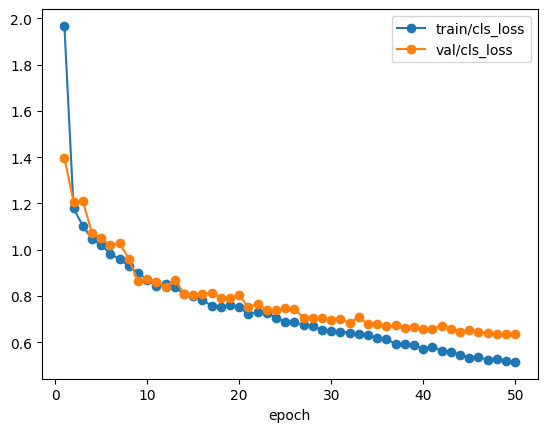

In [29]:
df[["train/cls_loss", "val/cls_loss"]].plot(marker="o");

In [30]:
saved_model = YOLO(save_dir / "weights" / "best.pt")
print(saved_model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_runnin

In [31]:
predict_results = saved_model.predict(
    "archive/test_images/0ad762bc-cam141_20250324_164622.jpg",
    conf=0.5,
    save=True,
)

f"Result type: {type(predict_results)}, length: {len(predict_results)}"


image 1/1 /Users/mac/road_users_detection/archive/test_images/0ad762bc-cam141_20250324_164622.jpg: 384x640 4 passenger_cars, 1 bus, 3 pedestrians, 77.1ms
Speed: 3.7ms preprocess, 77.1ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /Users/mac/road_users_detection/runs/detect/predict8


"Result type: <class 'list'>, length: 1"

In [32]:
predict_results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0., 3., 0., 5., 5., 5.])
conf: tensor([0.8564, 0.8486, 0.8238, 0.8145, 0.7635, 0.7087, 0.6970, 0.6733])
data: tensor([[2.4984e+02, 1.4011e+02, 3.6656e+02, 1.9913e+02, 8.5637e-01, 0.0000e+00],
        [5.4946e+02, 1.3589e+02, 6.2403e+02, 1.7926e+02, 8.4858e-01, 0.0000e+00],
        [1.4703e+01, 1.6687e+02, 9.4319e+01, 2.1467e+02, 8.2383e-01, 0.0000e+00],
        [5.7774e+02, 6.7963e+01, 6.4522e+02, 1.2535e+02, 8.1449e-01, 3.0000e+00],
        [6.2295e+02, 1.2150e+02, 6.6055e+02, 1.5181e+02, 7.6353e-01, 0.0000e+00],
        [1.2125e+03, 3.2267e+02, 1.2430e+03, 3.7896e+02, 7.0866e-01, 5.0000e+00],
        [3.8579e+02, 1.2528e+02, 4.0384e+02, 1.6650e+02, 6.9700e-01, 5.0000e+00],
        [6.9020e+02, 1.5608e+02, 7.1092e+02, 2.0100e+02, 6.7326e-01, 5.0000e+00]])
id: None
is_track: False
orig_shape: (720, 1280)
shape: torch.Size([8, 6])
xywh: tensor([[ 308.2014,  169.6202,  116.7264,   59.0175],
        [ 586.7457,

In [33]:
predict_results[0].boxes.cls.cpu()


tensor([0., 0., 0., 3., 0., 5., 5., 5.])

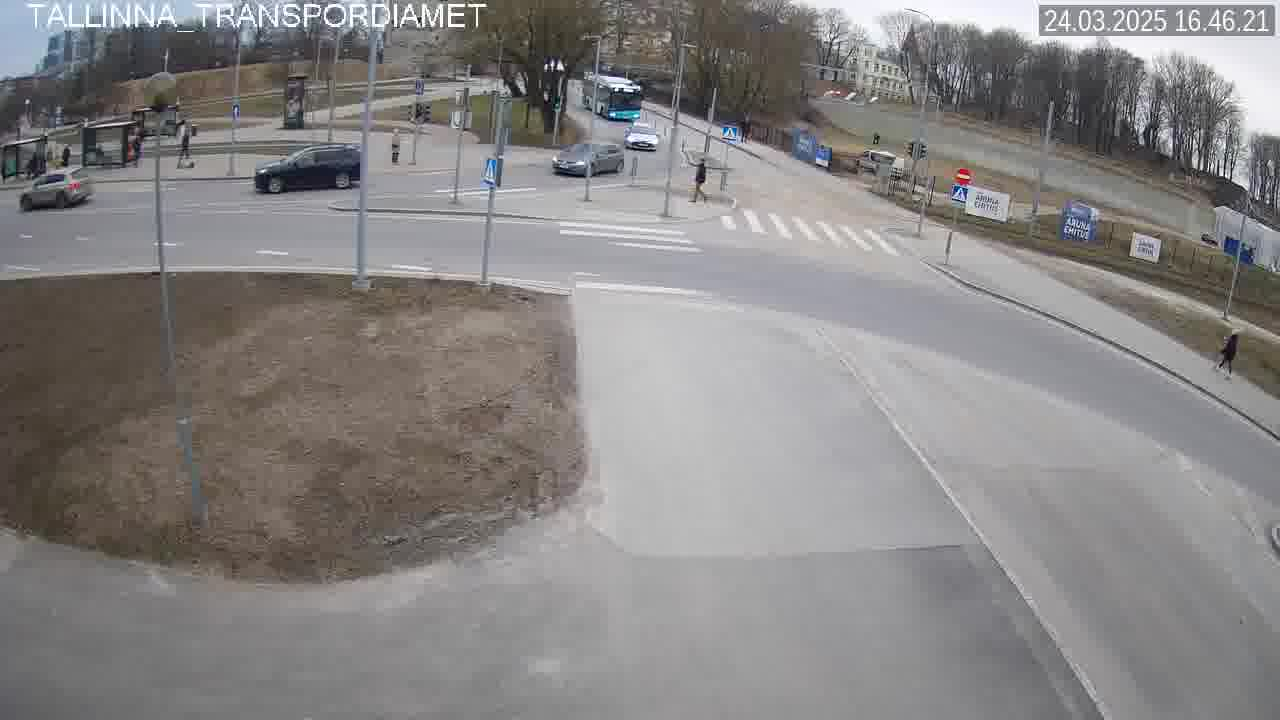

In [34]:
Image.open(pathlib.Path("archive/test_images/0ad762bc-cam141_20250324_164622.jpg"))

In [35]:
test_dir = Path("archive/test_images")
model = YOLO(save_dir / "weights" / "best.pt")

detected_objs = []

for img_path in test_dir.glob("*.jpg"):
    pred_results = model.predict(img_path, conf=0.5, save=False)[0]

    boxes = pred_results.boxes
    if boxes is None or len(boxes) == 0:
        continue

    xyxy = boxes.xyxy.cpu().numpy()
    confs = boxes.conf.cpu().numpy()
    clss = boxes.cls.cpu().numpy()

    for i in range(len(boxes)):
        xmin, ymin, xmax, ymax = xyxy[i]
        conf = float(confs[i])
        class_id = int(clss[i])
        class_name = classes[class_id]  # your class list

        detected_objs.append({
            "ID": len(detected_objs) ,
            "image_id": img_path.name,
            "confidence": conf,
            "class_name": class_name,
            "x_min": xmin,
            "y_min": ymin,
            "x_max": xmax,
            "y_max": ymax,
        })



image 1/1 /Users/mac/road_users_detection/archive/test_images/7a13387e-cam142_20250327_162719.jpg: 384x640 3 passenger_cars, 2 pedestrians, 53.5ms
Speed: 0.9ms preprocess, 53.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/mac/road_users_detection/archive/test_images/395f9a94-cam256_20250403_162938.jpg: 384x640 (no detections), 49.9ms
Speed: 1.0ms preprocess, 49.9ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/mac/road_users_detection/archive/test_images/24b47b40-cam087_20250327_163120.jpg: 384x640 9 passenger_cars, 1 utility_vehicle, 1 bus, 49.2ms
Speed: 1.0ms preprocess, 49.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/mac/road_users_detection/archive/test_images/2dfb1b96-cam141_20250324_164924.jpg: 384x640 9 passenger_cars, 1 tram, 4 pedestrians, 47.9ms
Speed: 0.9ms preprocess, 47.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users

In [36]:
df = pd.DataFrame(detected_objs)
df = df.set_index("ID")
df.head(20)


,image_id,confidence,class_name,x_min,y_min,x_max,y_max
ID,,,,,,,
0,7a13387e-cam142_20250327_162719.jpg,0.841163,passenger_car,345.803009,82.008698,417.112946,142.626617
1,7a13387e-cam142_20250327_162719.jpg,0.819180,passenger_car,373.038086,51.064606,430.104858,92.967865
2,7a13387e-cam142_20250327_162719.jpg,0.772183,pedestrian,219.152924,163.734375,255.082825,235.323029
3,7a13387e-cam142_20250327_162719.jpg,0.704774,passenger_car,328.439423,43.449921,361.573883,71.140076
4,7a13387e-cam142_20250327_162719.jpg,0.544139,pedestrian,1073.500977,454.146515,1156.997070,547.122803
5,24b47b40-cam087_20250327_163120.jpg,0.857983,passenger_car,304.576813,151.234924,420.090118,225.520294
6,24b47b40-cam087_20250327_163120.jpg,0.853483,passenger_car,694.269958,133.639282,812.770203,187.767761
7,24b47b40-cam087_20250327_163120.jpg,0.827246,passenger_car,835.235718,133.452286,920.838745,178.778763
8,24b47b40-cam087_20250327_163120.jpg,0.820803,bus,101.942963,201.428894,965.211304,685.679565
